# Spike-phase coupling and decoding: Phase precession and hippocampal sequences
This notebook has had all its explanatory text removed and has not been run.
 It is intended to be downloaded and run locally (or on the provided binder)
 while listening to the presenter's explanation. In order to see the fully
 rendered of this notebook, go [here](../../full/day1/phase_precession.md)

    
In this tutorial we will learn how to use more advanced applications of pynapple: signal processing and decoding. We'll apply these methods to demonstrate and visualize some well-known physiological properties of hippocampal activity, specifically phase presession of place cells and sequential coordination of place cell activity during theta oscillations.
## Objectives

    
We can break our goals of identifying phase presession and coordinated activity of place cells into the following objectives: 
1. Get a feel for the data set   
    - Load in and visualize the data
    - Restrict the data to regions of interest
2. Identify and extract theta oscillations in the LFP
    - Decompose the LFP into frequency components to identify theta oscillations
    - Filter the LFP to isolate the theta frequency band
3. Identify place cells
    - Calculate 1D tuning curves to identify place selectivity across many units
4. Visualize phase precession
    - Compare spike location to spike phase in a single unit
    - Calculate 2D tuning curves to identify place vs phase selectivity across many units
5. Reconstruct spatial sequences from population activity
    - Apply Bayesian decoding to predict position from spiking activity
    - Decode at a fast time-scale to identify spatial "sweeps" coordinated with theta oscillations

In [1]:
# suppress warnings
import warnings
warnings.simplefilter("ignore")

# imports
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from scipy import signal
import seaborn as sns
import tqdm
import pynapple as nap
import workshop_utils

# necessary for animation
import nemos as nmo
plt.style.use(nmo.styles.plot_style)

## Fetching the data

First we'll fetch the relevant data set for this exercise.

- Manuscript: [Diversity in neural firing dynamics supports both rigid and learned hippocampal sequences](https://www.science.org/doi/10.1126/science.aad1935)
- Full data source: [DANDI](https://dandiarchive.org/dandiset/000044/0.210812.1516)

In [2]:
# fetch file path
path = workshop_utils.fetch_data("Achilles_10252013_EEG.nwb")
# load data with pynapple
data = nap.load_file(path)
print(data)

Achilles_10252013_EEG
┍━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys        │ Type        │
┝━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units       │ TsGroup     │
│ rem         │ IntervalSet │
│ nrem        │ IntervalSet │
│ forward_ep  │ IntervalSet │
│ eeg         │ TsdFrame    │
│ theta_phase │ Tsd         │
│ position    │ Tsd         │
┕━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙


:::{admonition} Note
:class: note render-all
We will ignore the object `theta_phase` because we will be computing this ourselves later on in the exercise.
:::
### units

    
The `units` field is a `TsGroup`: a collection of `Ts` objects containing the spike times of each unit, where the "Index" is the unit number or key. Each unit has the following metadata:
- **rate**: computed by pynapple, is the average firing rate of the neuron across all recorded time points.
- **location**, **shank**, and **cell_type**: variables saved and imported from the original data set.

In [3]:
data["units"]

Index    rate     location    shank    cell_type
-------  -------  ----------  -------  -----------
1        1.56775  ca1         1        pE
2        9.12029  ca1         1        pI
6        0.14618  ca1         1        pE
7        1.40307  ca1         1        pE
9        0.22848  ca1         1        pE
11       0.4157   ca1         1        pE
12       1.57063  ca1         1        pE
...      ...      ...         ...      ...
266      0.6839   ca1         13       pE
267      3.0145   ca1         13       pI
268      0.86567  ca1         13       pE
269      0.28607  ca1         13       pE
270      0.30931  ca1         13       pE
271      0.35912  ca1         13       pE
272      0.62102  ca1         13       pE

We can access the spike times of a single unit by indexing the `TsGroup` by its unit number. For example, to access the spike times of unit 1:

In [4]:
data["units"][1]

Time (s)
12683.7723
12688.18085
12691.3421
12691.62475
12691.77515
12695.471
12700.2699
...
25536.359
25539.8976
25539.9318
25545.21125
25545.21885
25545.22585
25545.2324
shape: 20173

### rem, nrem, and forward_ep


The next three objects; `rem`, `nrem`, and `forward_ep`; are all IntervalSets containing time windows of REM sleep, nREM sleep, and forward runs down the linear maze, respectively.

In [5]:
data["rem"]

  index    start    end
      0    13747  13934
      1    15963  15991
      2    16035  16214
      3    22521  22573
shape: (4, 2), time unit: sec.

In [6]:
data["nrem"]

  index    start    end
      0    12892  13746
      1    13971  15963
      2    15991  16034
      3    16241  16565
      4    16837  16874
      5    17059  18076
      6    21350  21399
      7    22068  22520
      8    22635  22745
      9    24326  24419
     10    24953  25547
shape: (11, 2), time unit: sec.

In [7]:
data["forward_ep"]

index    start            end
0        18193.598802655  18197.489989104
1        18198.437185805  18201.30437582
2        18240.625838885  18243.083430326
3        18273.95692281   18276.414514252
4        18315.940776603  18318.244768579
5        18347.377467126  18347.761465788
6        18350.193457319  18350.500656249
...      ...              ...
77       18193.598802655  18197.489989104
78       18198.437185805  18201.30437582
79       18240.625838885  18243.083430326
80       18273.95692281   18276.414514252
81       18315.940776603  18318.244768579
82       18347.377467126  18347.761465788
83       18350.193457319  18350.500656249
shape: (84, 2), time unit: sec.

    
The following plot demonstrates how each of these labelled epochs are organized across the session.

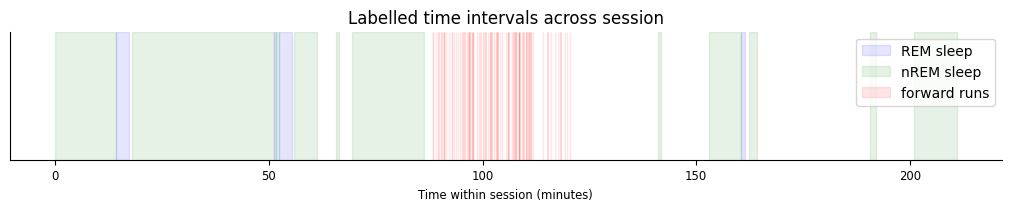

In [8]:
t_start = data["nrem"].start[0]
fig,ax = plt.subplots(figsize=(10,2), constrained_layout=True)
sp1 = [ax.axvspan((iset.start[0]-t_start)/60, (iset.end[0]-t_start)/60, color="blue", alpha=0.1) for iset in data["rem"]];
sp2 = [ax.axvspan((iset.start[0]-t_start)/60, (iset.end[0]-t_start)/60, color="green", alpha=0.1) for iset in data["nrem"]];
sp3 = [ax.axvspan((iset.start[0]-t_start)/60, (iset.end[0]-t_start)/60, color="red", alpha=0.1) for iset in data["forward_ep"]];
ax.set(xlabel="Time within session (minutes)", title="Labelled time intervals across session", yticks=[])
ax.legend([sp1[0],sp2[0],sp3[0]], ["REM sleep","nREM sleep","forward runs"]);

### eeg


The `eeg` object is a `TsdFrame` containing an LFP voltage trace for a single representative channel in CA1.

In [9]:
data["eeg"]

Time (s)    1
----------  ----
12679.5     -258
12679.5008  -341
12679.5016  -355
12679.5024  -379
12679.5032  -364
12679.504   -406
12679.5048  -508
...         ...
25546.9696  2035
25546.9704  2021
25546.9712  2023
25546.972   1906
25546.9728  1848
25546.9736  1862
25546.9744  1976
dtype: int16, shape: (16084344, 1)

Despite having a single column, this `TsdFrame` is still a 2D object. We can represent this as a 1D `Tsd` by indexing into the first column.

In [10]:
data["eeg"][:,0]

Time (s)
----------  ----
12679.5     -258
12679.5008  -341
12679.5016  -355
12679.5024  -379
12679.5032  -364
12679.504   -406
12679.5048  -508
...
25546.9696  2035
25546.9704  2021
25546.9712  2023
25546.972   1906
25546.9728  1848
25546.9736  1862
25546.9744  1976
dtype: int16, shape: (16084344,)

### 

### position


The final object, `position`, is a `Tsd` containing the linearized position of the animal, in centimeters, recorded during the exploration window.

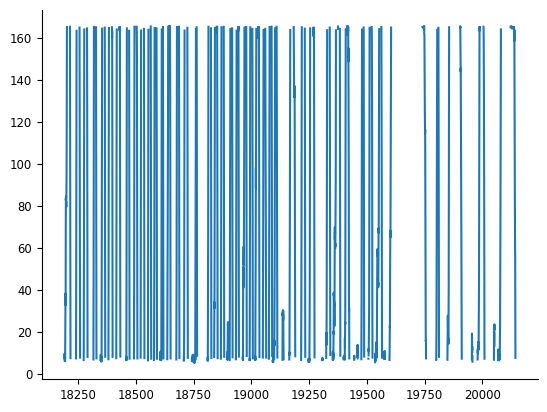

In [11]:
data["position"]
plt.plot(data["position"])

Positions that are not defined, i.e. when the animal is at rest, are filled with `NaN`.

This object additionally contains a `time_support` attribute, which gives the time interval during which positions are recorded (including points recorded as `NaN`).

In [12]:
data["position"].time_support

  index    start    end
      0  18079.5  20147
shape: (1, 2), time unit: sec.

Let's visualize the first 300 seconds of position data and overlay `forward_ep` intervals.

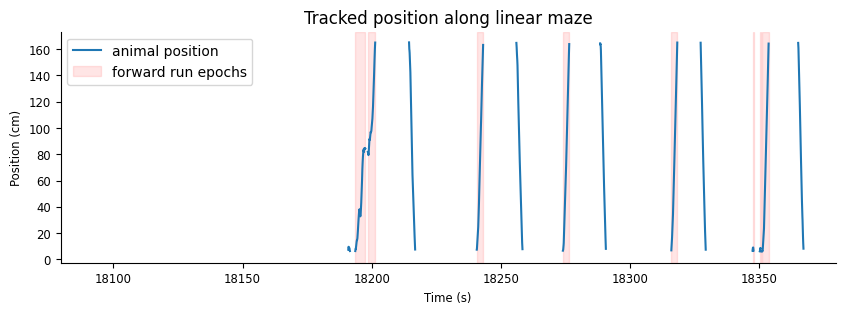

In [13]:
pos_start = data["position"].time_support.start[0]
fig, ax = plt.subplots(figsize=(10,3))
l1 = ax.plot(data["position"])
l2 = [ax.axvspan(iset.start[0], iset.end[0], color="red", alpha=0.1) for iset in data["forward_ep"]];
ax.set(xlim=[pos_start,pos_start+300], ylabel="Position (cm)", xlabel="Time (s)", title="Tracked position along linear maze")
ax.legend([l1[0], l2[0]], ["animal position", "forward run epochs"])

## Restricting the data

    
For the following exercises, we'll only focus on periods when the animal is awake. We'll start by pulling out `forward_ep` from the data.

In [14]:
forward_ep = data["forward_ep"]

Since `forward_ep` is formatted as discontinuous epochs when the animal is running down the track, we will want two additional IntervalSets to describe the exploration period:

1. An IntervalSet with a single interval for the entire awake period
2. An IntervalSet containing the intervals at which the animal is at rest.

We can derive both of these from `forward_ep`. 

For the first, we can use the `IntervalSet` method `time_span`, which will give the total epoch spanning all the intervals in `forward_ep`.

In [15]:
forward_ep.time_span()

  index    start      end
      0  18193.6  20123.4
shape: (1, 2), time unit: sec.

In [16]:
awake_ep = forward_ep.time_span()

For the second, we know that the animal is likely at rest when there is no recorded position (i.e. the position is NaN). We can create this `IntervalSet`, then, using the following steps.

1. Drop `NaN` values from the position to grab only points where position is defined.

In [17]:
# drop nan values
pos_good = data['position'].dropna()
pos_good

Time (s)
---------------  --------
18190.885212105   7.34295
18190.910812016   8.11589
18190.936411926   8.63119
18190.962011837   9.14648
18190.987611748   9.53295
18191.013211659   9.53295
18191.03881157    9.40413
...
20143.08321364   14.2994
20143.108813551  13.0112
20143.134413462  11.8518
20143.160013373  10.8212
20143.185613283   9.91942
20143.211213194   8.88884
20143.236813105   7.6006
dtype: float64, shape: (12847,)

2. Extract time intervals from `pos_good` using the `find_support` method
   - The first input argument, `min_gap`, sets the minumum separation between adjacent intervals in order to be split
   - Here, use `min_gap` of 1 s

In [18]:
# extract time support
position_ep = pos_good.find_support(1)
position_ep

index    start            end
0        18190.885212105  18191.525210876
1        18193.598802655  18201.30437682
2        18214.411530175  18216.766722973
3        18240.625838885  18243.083431326
4        18255.960185483  18258.315378281
5        18273.95692281   18276.414515252
6        18288.369672618  18290.596865862
...      ...              ...
107      18190.885212105  18191.525210876
108      18193.598802655  18201.30437682
109      18214.411530175  18216.766722973
110      18240.625838885  18243.083431326
111      18255.960185483  18258.315378281
112      18273.95692281   18276.414515252
113      18288.369672618  18290.596865862
shape: (114, 2), time unit: sec.

3. Define resting epochs as the set difference between `awake_ep` and `position_ep`, using the `set_diff` method.
   - `set_diff` should be applied to `awake_ep`, not the other way around, such that intervals in `position_ep` are subtracted out of `awake_ep`

In [19]:
rest_ep = awake_ep.set_diff(position_ep)
rest_ep

index    start            end
0        18201.30437682   18214.411530175
1        18216.766722973  18240.625838885
2        18243.083431326  18255.960185483
3        18258.315378281  18273.95692281
4        18276.414515252  18288.369672618
5        18290.596865862  18315.940776603
6        18318.244769579  18327.281537109
...      ...              ...
103      18201.30437682   18214.411530175
104      18216.766722973  18240.625838885
105      18243.083431326  18255.960185483
106      18258.315378281  18273.95692281
107      18276.414515252  18288.369672618
108      18290.596865862  18315.940776603
109      18318.244769579  18327.281537109
shape: (110, 2), time unit: sec.

:::{admonition} Note
:class: note render-all

Performing `set_diff` between `awake_ep` and `forward_ep` will *not* give us purely resting epochs, since these intervals will also include times when the animal is moving *backwards* across the linear track.

:::

    
Now, when extracting the LFP, spikes, and position, we can use `restrict()` with `awake_ep` to restrict the data to our region of interest.

In [20]:
lfp_run = data["eeg"][:,0].restrict(awake_ep)
spikes = data["units"].restrict(awake_ep)
position = data["position"].restrict(awake_ep)

    
For visualization, we'll look at a single run down the linear track. For a good example, we'll start by looking at run 10 (python index 9). Furthermore, we'll add two seconds on the end of the run to additionally visualize a period of rest following the run.

In [21]:
ex_run_ep = nap.IntervalSet(start=forward_ep[9].start, end=forward_ep[9].end+2)
ex_run_ep

  index    start      end
      0  18414.9  18419.1
shape: (1, 2), time unit: sec.

## Plotting the LFP and animal position


To get a sense of what the LFP looks like while the animal runs down the linear track, we can plot each variable, `lfp_run` and `position`, side-by-side. 

We'll want to further restrict each variable to our run of interest, `ex_run_ep`.

In [22]:
ex_lfp_run = lfp_run.restrict(ex_run_ep)
ex_position = position.restrict(ex_run_ep)

Let's plot the example LFP trace and anmimal position. Plotting `Tsd` objects will automatically put time on the x-axis.

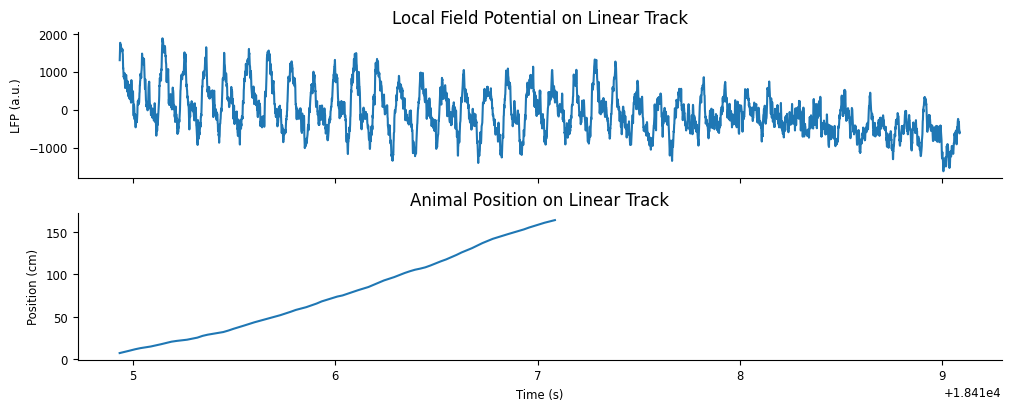

In [23]:
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 4), sharex=True)

# plot LFP
axs[0].plot(ex_lfp_run)
axs[0].set_title("Local Field Potential on Linear Track")
axs[0].set_ylabel("LFP (a.u.)")

# plot animal's position
axs[1].plot(ex_position)
axs[1].set_title("Animal Position on Linear Track")
axs[1].set_ylabel("Position (cm)") # LOOK UP UNITS
axs[1].set_xlabel("Time (s)");

## Getting the Wavelet Decomposition


To illustrate this further, we'll perform a wavelet decomposition on the LFP trace during this run. We can do this in pynapple using the function `nap.compute_wavelet_transform`. This function takes the following inputs (in order):
- `sig`: the input signal; a `Tsd`, a `TsdFrame`, or a `TsdTensor`
- `freqs`: a 1D array of frequency values to decompose

We will also supply the following optional arguments:
- `fs`: the sampling rate of `sig`

1. Define 100 log-spaced samples between 5 and 200 Hz using `np.geomspace`

In [24]:
# 100 log-spaced samples between 5Hz and 200Hz
freqs = np.geomspace(5, 200, 100)
freqs

array([  5.        ,   5.18982159,   5.38684963,   5.5913577 ,
         5.80362979,   6.02396063,   6.25265619,   6.49003402,
         6.73642374,   6.99216747,   7.25762034,   7.53315095,
         7.81914189,   8.11599028,   8.42410832,   8.74392385,
         9.07588096,   9.42044059,   9.77808119,  10.14929938,
        10.53461061,  10.93454992,  11.34967265,  11.78055524,
        12.22779598,  12.69201592,  13.17385965,  13.67399625,
        14.1931202 ,  14.73195233,  15.29124085,  15.87176239,
        16.47432303,  17.09975947,  17.74894018,  18.42276659,
        19.12217436,  19.84813467,  20.60165557,  21.38378338,
        22.19560414,  23.03824512,  23.91287639,  24.82071243,
        25.76301386,  26.74108912,  27.75629633,  28.8100452 ,
        29.90379892,  31.03907626,  32.21745363,  33.44056729,
        34.71011563,  36.0278615 ,  37.3956347 ,  38.81533447,
        40.28893218,  41.81847402,  43.40608388,  45.05396626,
        46.76440937,  48.53978829,  50.38256826,  52.29

2. Compute the wavelet transform, supplying the known sampling rate of 1250 Hz.

In [25]:
sample_rate = 1250
cwt_run = nap.compute_wavelet_transform(ex_lfp_run, freqs, 1250)

If `fs` is not provided, it can be inferred from the time series `rate` attribute.

In [26]:
print(ex_lfp_run.rate)

1250.0022555092703


We can visualize the results by plotting a heat map of the calculated wavelet scalogram.

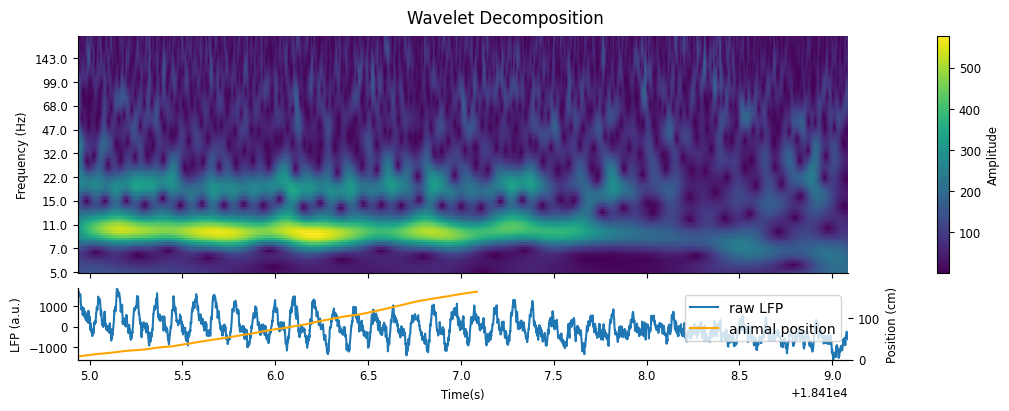

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(10,4), constrained_layout=True, height_ratios=[1.0, 0.3], sharex=True)
fig.suptitle("Wavelet Decomposition")

amp = np.abs(cwt_run.values)
cax = axs[0].pcolormesh(cwt_run.t, freqs, amp.T)
axs[0].set(ylabel="Frequency (Hz)", yscale='log', yticks=freqs[::10], yticklabels=np.rint(freqs[::10]));
axs[0].minorticks_off()
fig.colorbar(cax,label="Amplitude")

p1 = axs[1].plot(ex_lfp_run)
axs[1].set(ylabel="LFP (a.u.)", xlabel="Time(s)")
axs[1].margins(0)
ax = axs[1].twinx()
p2 = ax.plot(ex_position, color="orange")
ax.set_ylabel("Position (cm)")
ax.legend([p1[0], p2[0]],["raw LFP","animal position"])

## Bonus: Additional signal processing methods

    
- `nap.compute_fft`

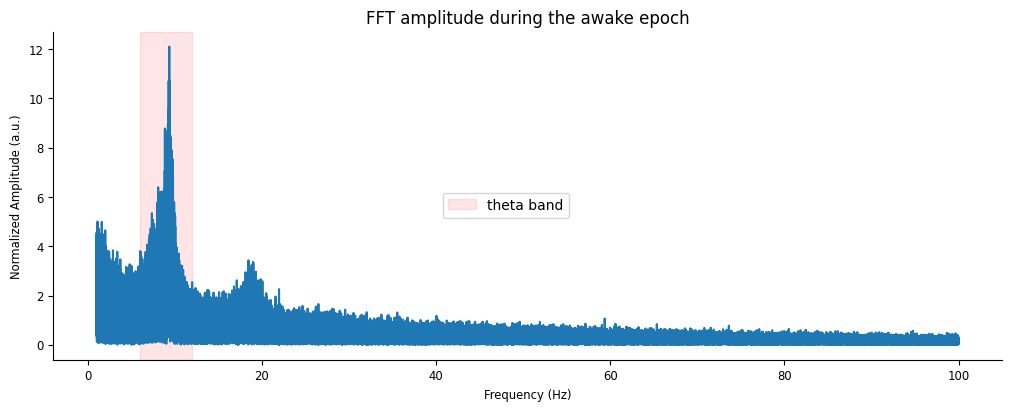

In [28]:
fft_amp = np.abs(nap.compute_fft(lfp_run, fs=sample_rate, norm=True))
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(fft_amp[(fft_amp.index >= 1) & (fft_amp.index <= 100)])
ax.axvspan(6, 12, color="red", alpha=0.1, label = "theta band")
ax.set(xlabel="Frequency (Hz)", ylabel="Normalized Amplitude (a.u.)", title="FFT amplitude during the awake epoch")
fig.legend(loc="center")

    
- `nap.compute_power_spectral_density`

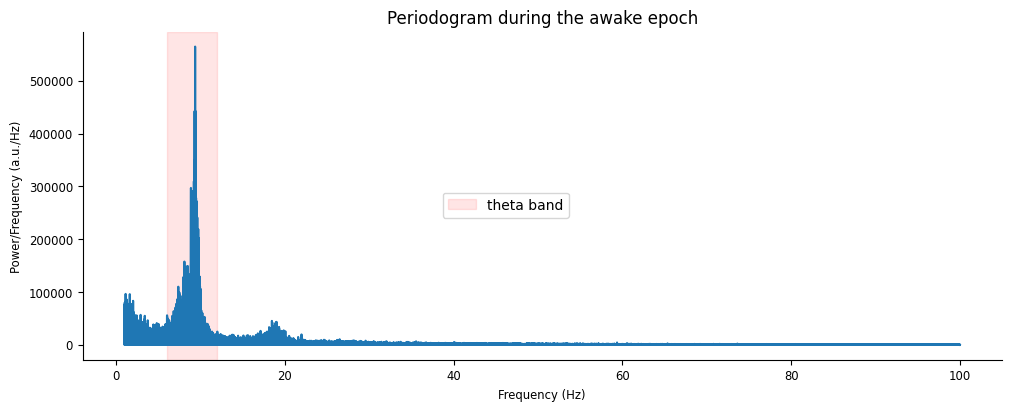

In [29]:
power = nap.compute_power_spectral_density(lfp_run, fs=sample_rate)
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(power[(power.index >= 1) & (power.index <= 100)])
ax.axvspan(6, 12, color="red", alpha=0.1, label = "theta band")
ax.set(xlabel="Frequency (Hz)", ylabel="Power/Frequency (a.u./Hz)", title="Periodogram during the awake epoch")
fig.legend(loc="center")

## Filtering for theta


For the remaining exercises, we'll reduce our example epoch to the portion when the animal is running down the linear track.

In [32]:
ex_run_ep = forward_ep[9]
ex_lfp_run = lfp_run.restrict(ex_run_ep)
ex_position = position.restrict(ex_run_ep)

We can filter our signal for theta by using `nap.apply_bandpass_filter`, which requires following arguments:
- `data`: the signal to be filtered; a `Tsd`, `TsdFrame`, or `TsdTensor`
- `cutoff`: tuple containing the frequency cutoffs, (lower frequency, upper frequency)

Same as before, we'll pass the optional argument:
- `fs`: the sampling rate of `data` in Hz

Using this function, filter `lfp_run` within a 6-12 Hz range.

In [33]:
theta_band = nap.apply_bandpass_filter(ex_lfp_run, (6, 12), fs=1250)

We can visualize the output by plotting the filtered signal with the original signal.

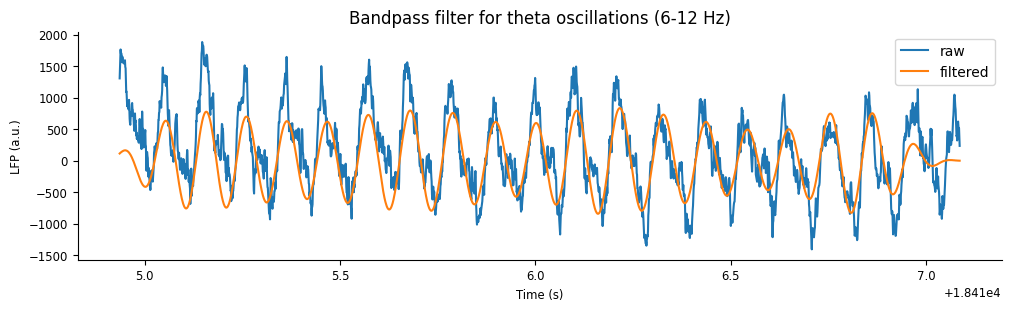

In [34]:
plt.figure(constrained_layout=True, figsize=(10, 3))
plt.plot(ex_lfp_run, label="raw")
plt.plot(theta_band.restrict(ex_run_ep), label="filtered")
plt.xlabel("Time (s)")
plt.ylabel("LFP (a.u.)")
plt.title("Bandpass filter for theta oscillations (6-12 Hz)")
plt.legend();

## Computing theta phase


In order to examine phase precession in place cells, we need to extract the phase of theta from the filtered signal. We can do this by taking the angle of the [Hilbert transform](https://en.wikipedia.org/wiki/Hilbert_transform).

The `signal` module of `scipy` includes a function to perform the Hilbert transform, after which we can use the numpy function `np.angle` to extract the angle.

In [36]:
import scipy as sp

## )

In [46]:
angle = np.angle(sp.signal.hilbert(theta_band)) + np.pi # Make it 0 to 2pi

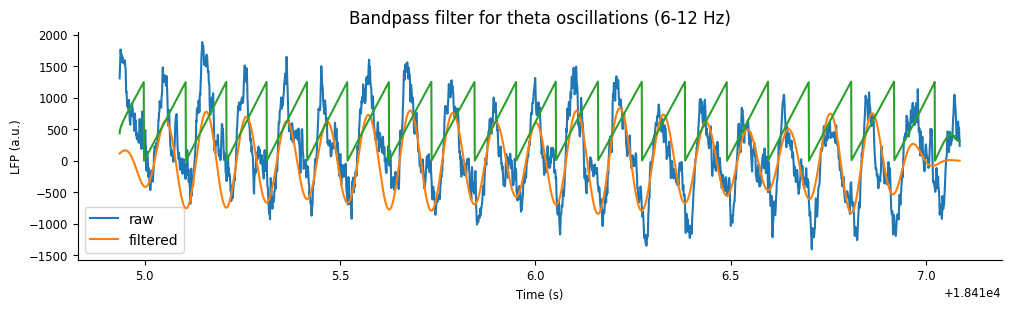

In [49]:
plt.figure(constrained_layout=True, figsize=(10, 3))
plt.plot(ex_lfp_run, label="raw")
plt.plot(theta_band.restrict(ex_run_ep), label="filtered")
plt.plot(ex_lfp_run.t, angle * 200)
plt.xlabel("Time (s)")
plt.ylabel("LFP (a.u.)")
plt.title("Bandpass filter for theta oscillations (6-12 Hz)")
plt.legend();

The output angle will be in the range $-\pi$ to $\pi$. Converting this to a $0$ to $2\pi$ range instead, by adding $2\pi$ to negative angles, will make later visualization more interpretable.

In [ ]:
# enter code here

Finally, we need to turn this into a `Tsd` to make full use of pynapple's conveniences! Do this using the time index of `theta_band`.

In [50]:
theta_phase = nap.Tsd(t=theta_band.t, d=angle)

Let's plot the phase on top of the filtered LFP signal.

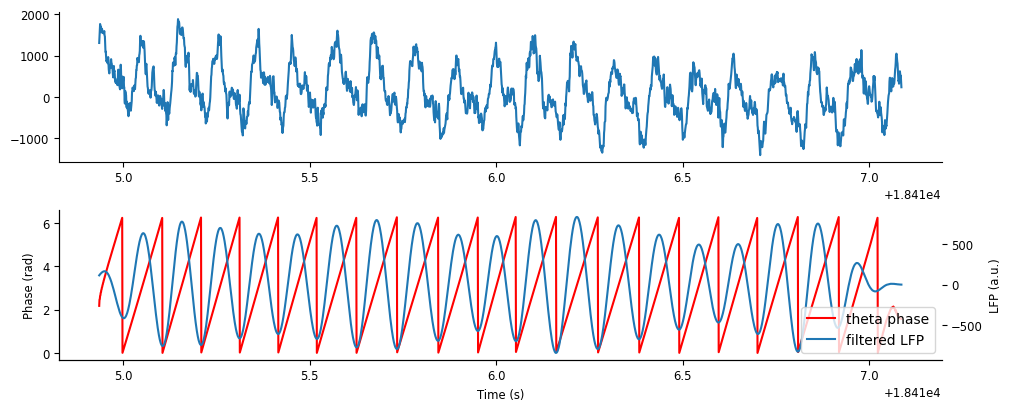

In [51]:
fig,axs = plt.subplots(2,1,figsize=(10,4), constrained_layout=True) #, sharex=True, height_ratios=[2,1])

ax = axs[0]
ax.plot(ex_lfp_run)

ax = axs[1]
p1 = ax.plot(theta_phase.restrict(ex_run_ep), color='r')
ax.set_ylabel("Phase (rad)")
ax.set_xlabel("Time (s)")
ax = ax.twinx()
p2 = ax.plot(theta_band.restrict(ex_run_ep))
ax.set_ylabel("LFP (a.u.)")
ax.legend([p1[0],p2[0]],["theta phase","filtered LFP"])

Let's zoom in on a few cycles to get a better look.

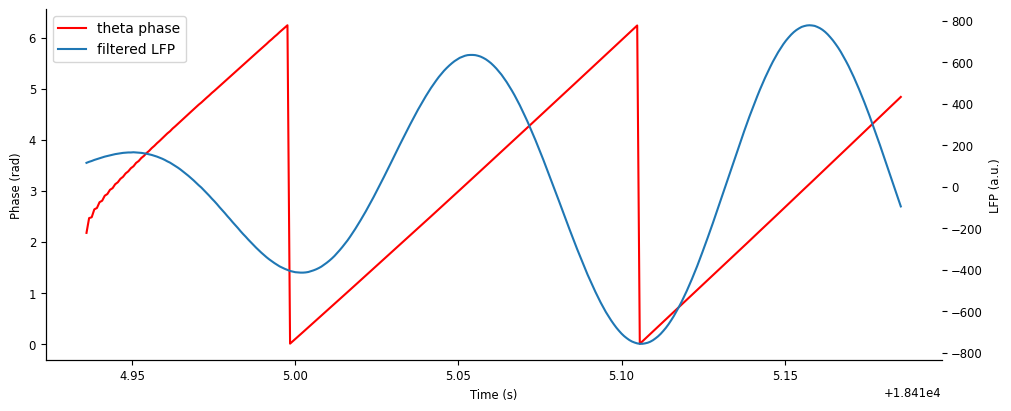

In [52]:
fig,ax = plt.subplots(figsize=(10,4), constrained_layout=True) #, sharex=True, height_ratios=[2,1])

ex_run_shorter = nap.IntervalSet(ex_run_ep.start[0], ex_run_ep.start[0]+0.25)

p1 = ax.plot(theta_phase.restrict(ex_run_shorter), color='r')
ax.set_ylabel("Phase (rad)")
ax.set_xlabel("Time (s)")
ax = ax.twinx()
p2 = ax.plot(theta_band.restrict(ex_run_shorter))
ax.set_ylabel("LFP (a.u.)")
ax.legend([p1[0],p2[0]],["theta phase","filtered LFP"])

## Computing 1D tuning curves: place fields


In order to identify phase precession in single units, we need to know their place selectivity. We can find place firing preferences of each unit by using the function `nap.compute_1d_tuning_curves`. This function has the following required inputs:
- `group`: a `TsGroup` of units for which tuning curves are computed
- `feature`: a `Tsd` or single-column `TsdFrame` of the feature over which tuning curves are computed (e.g. position)
- `nb_bins`: the number of bins in which to split the feature values for the tuning curve

First, we'll filter for units that fire at least 1 Hz and at most 10 Hz when the animal is running forward along the linear track. This will select for units that are active during our window of interest and eliminate putative interneurons (i.e. fast-firing inhibitory neurons that don't usually have place selectivity).

1. Restrict `spikes` to `forward_ep`

In [53]:
forward_spikes = spikes.restrict(forward_ep)  #nap.compute_1d_tuning_curves(spikes.restrict(forward_ep), position.restrict(forward_ep), nb_bins=

2. Select for units whose rate is at least 1 Hz and at most 10 Hz

In [58]:
good_spikes = forward_spikes[forward_spikes.rate >= 1]
good_spikes = forward_spikes[forward_spikes.rate <= 10]

Using these units and the position data, we can compute their place fields using `nap.compute_1d_tuning_curves`. This function will return a `pandas.DataFrame`, where the index is the corresponding feature value, and the column is the unit label. Let's compute this for 50 position bins.
:::{admonition} Tip
:class: tip render-all

The reason `nap.compute_1d_tuning_curves` returns a `pandas.DataFrame` and not a Pynapple object is because the index corresponds to the *feature*, where all Pynapple objects assume the index is *time*.
:::

In [88]:
place_fields = nap.compute_1d_tuning_curves(good_spikes, position, nb_bins=50, ep=forward_ep)

We can use a subplot array to visualize the place fields of many units simultaneously. Let's do this for the first 50 units.

Text(0.5, 0.01, 'Position (cm)')

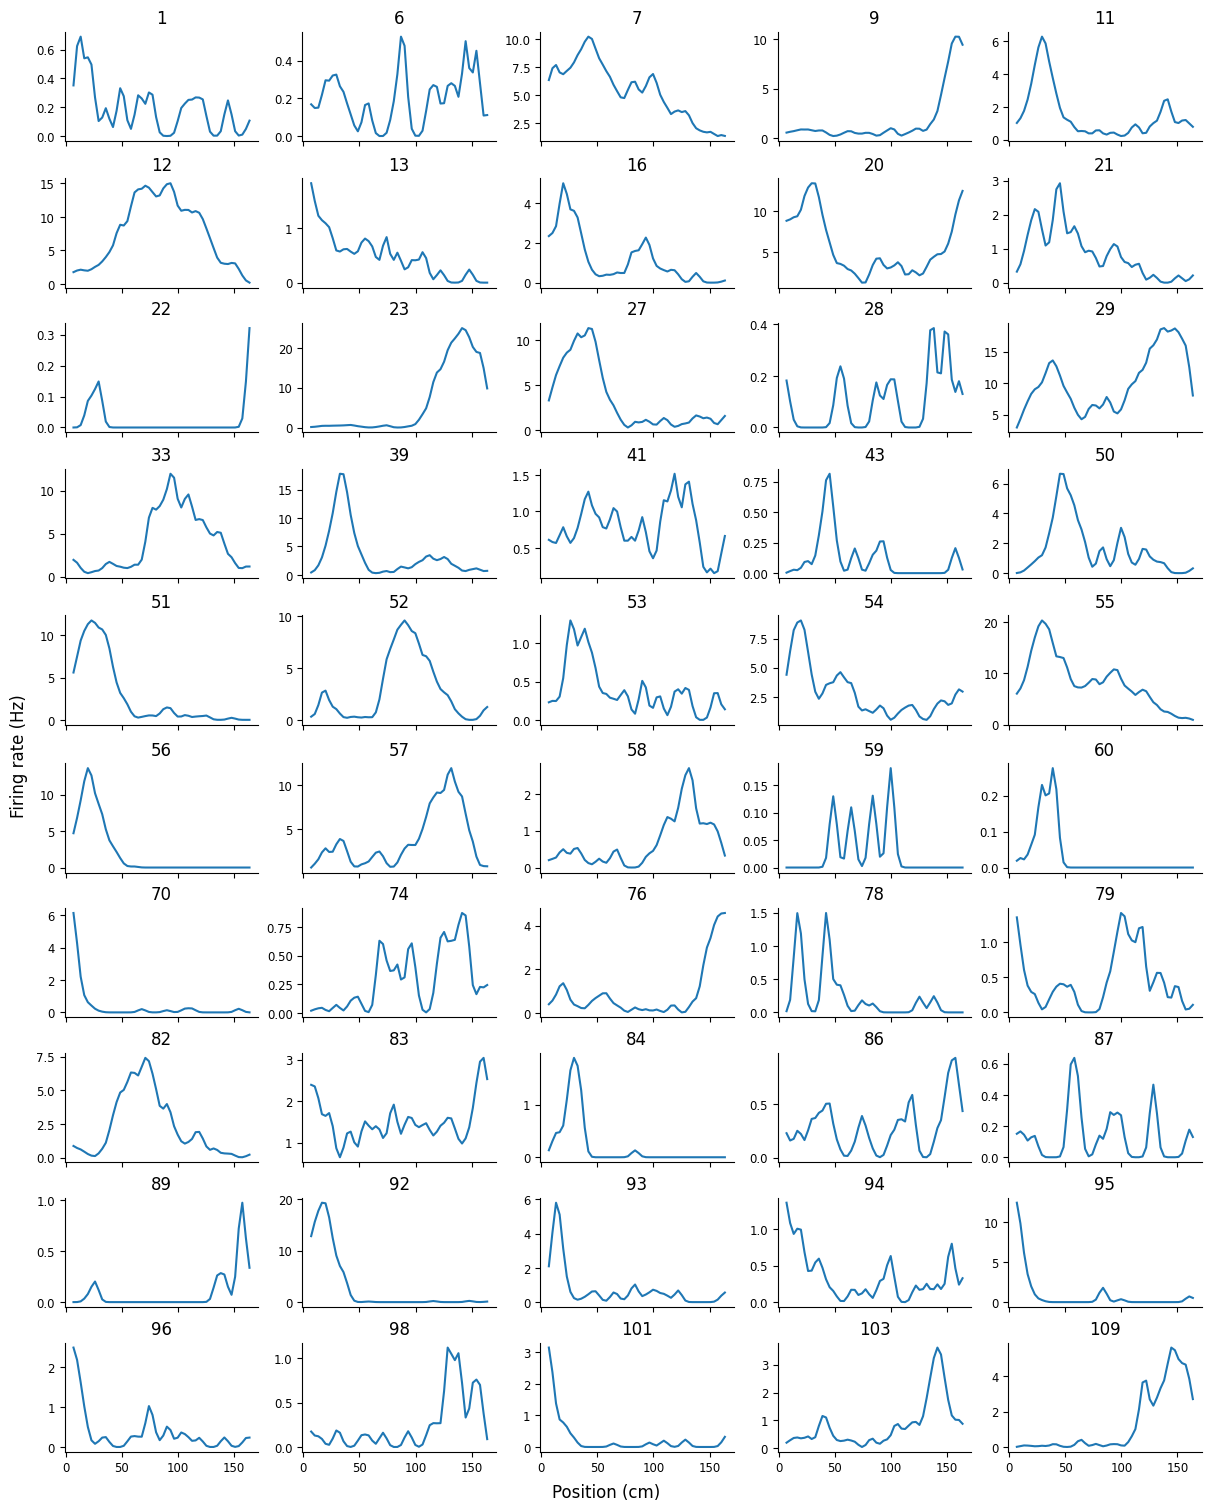

In [89]:
from scipy.ndimage import gaussian_filter1d

# smooth the place fields so they look nice
place_fields[:] = gaussian_filter1d(place_fields.values, 1, axis=0)

fig, axs = plt.subplots(10, 5, figsize=(12, 15), sharex=True, constrained_layout=True)
for i, (f, fields) in enumerate(place_fields.iloc[:,:50].items()):
    idx = np.unravel_index(i, axs.shape)
    axs[idx].plot(fields)
    axs[idx].set_title(f)

fig.supylabel("Firing rate (Hz)")
fig.supxlabel("Position (cm)")

## Visualizing phase precession within a single unit

First, let's look at how an example unit fires with respect to the filtered LFP. Using the pynapple object method `value_from`, we can find the value of `theta_band` corresponding to each spike time. Let's do this for unit 177, who's place field is cenetered on the linear track.

In [90]:
unit = 177
spike_theta = good_spikes[177].value_from(theta_band)

Let's plot `spike_theta` on top of the LFP and filtered theta, as well as visualize the animal's position along the track.

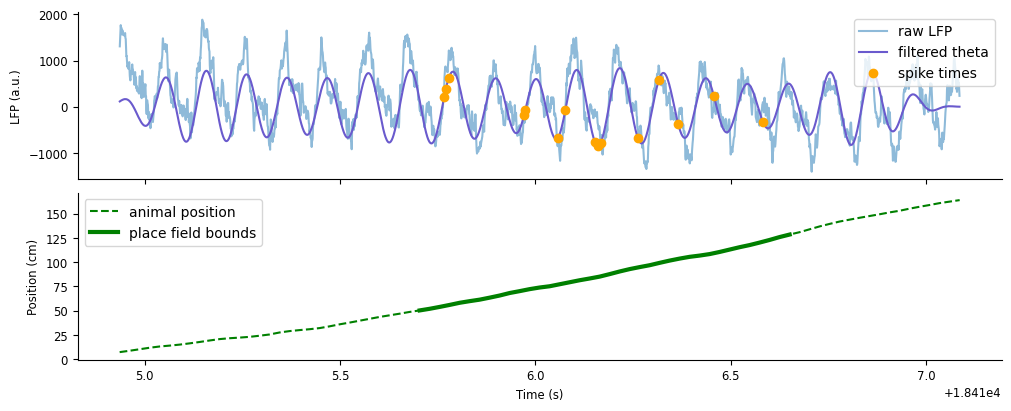

In [91]:
fig,axs = plt.subplots(2, 1, figsize=(10,4), constrained_layout=True, sharex=True)
axs[0].plot(ex_lfp_run, alpha=0.5, label="raw LFP")
axs[0].plot(theta_band.restrict(ex_run_ep), color="slateblue", label="filtered theta")
axs[0].plot(spike_theta.restrict(ex_run_ep), 'o', color="orange", label="spike times")
axs[0].set(ylabel="LFP (a.u.)")
axs[0].legend()

axs[1].plot(ex_position, '--', color="green", label="animal position")
axs[1].plot(ex_position[(ex_position > 50).values & (ex_position < 130).values], color="green", lw=3, label="place field bounds")
axs[1].set(ylabel="Position (cm)", xlabel="Time (s)")
axs[1].legend()

As the animal runs through unit 177's place field (thick green), the unit spikes (orange dots) at specific points along the theta cycle dependent on position: starting at the rising edge, moving towards the trough, and ending at the falling edge.

We can exemplify this pattern by plotting the spike times aligned to the phase of theta. Let's compute the phase at which each spike occurs by using `value_from` with `theta_phase`.

In [92]:
spike_phase = good_spikes[unit].value_from(theta_phase)

To visualize the results, we'll recreate the plot above, but instead with the theta phase.

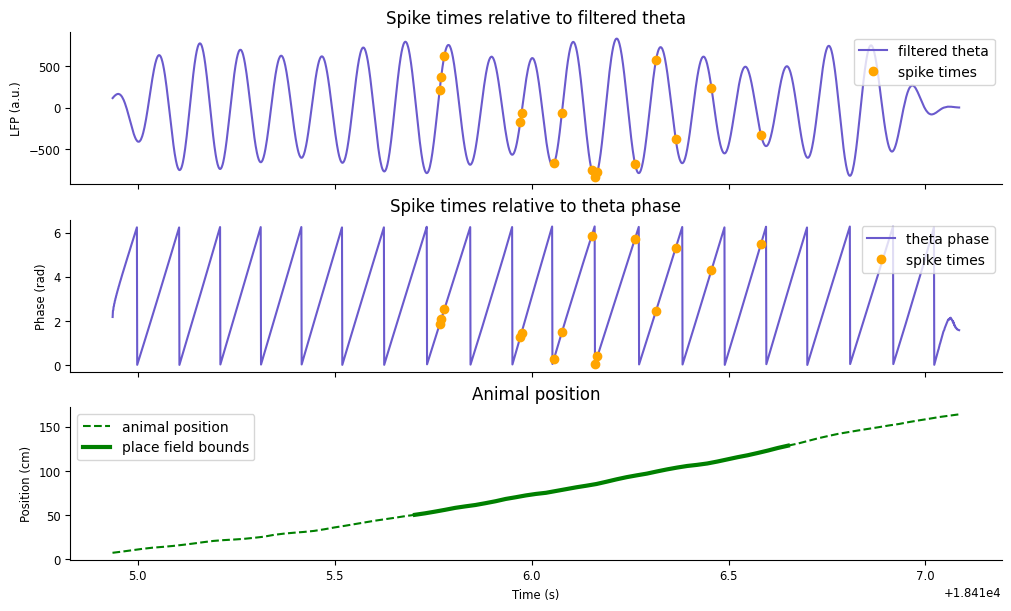

In [93]:
fig,axs = plt.subplots(3, 1, figsize=(10,6), constrained_layout=True, sharex=True)
axs[0].plot(theta_band.restrict(ex_run_ep), color="slateblue", label="filtered theta")
axs[0].plot(spike_theta.restrict(ex_run_ep), 'o', color="orange", label="spike times")
axs[0].set(ylabel="LFP (a.u.)", title="Spike times relative to filtered theta")
axs[0].legend()

axs[1].plot(theta_phase.restrict(ex_run_ep), color="slateblue", label="theta phase")
axs[1].plot(spike_phase.restrict(ex_run_ep), 'o', color="orange", label="spike times")
axs[1].set(ylabel="Phase (rad)", title="Spike times relative to theta phase")
axs[1].legend()

axs[2].plot(ex_position, '--', color="green", label="animal position")
axs[2].plot(ex_position[(ex_position > 50).values & (ex_position < 130).values], color="green", lw=3, label="place field bounds")
axs[2].set(ylabel="Position (cm)", xlabel="Time (s)", title="Animal position")
axs[2].legend()

We now see a negative trend in the spike phase as the animal moves through unit 177's place field, indicative of this unit *phase precessing*. 

We can observe this phenomena on average across the session by relating the spike phase to the spike position. Try computing the spike position from what we've learned so far.

In [86]:
spike_position = good_spikes[unit].value_from(position)

Now we can plot the spike phase against the spike position in a scatter plot.

ValueError: x and y must have same first dimension, but have shapes (349,) and (15,)

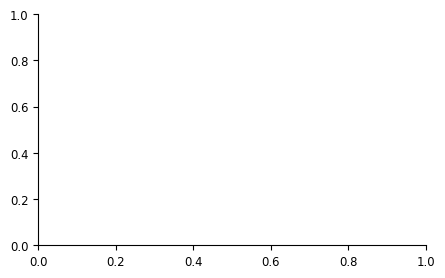

In [87]:
plt.subplots(figsize=(5,3))
plt.plot(spike_position, spike_phase, 'o')
plt.ylabel("Phase (rad)")
plt.xlabel("Position (cm)")

## Computing 2D tuning curves: position vs. phase


The scatter plot above can be similarly be represented as a 2D tuning curve over position and phase. We can compute this using the function `nap.compute_2d_tuning_curves`. This function requires the same inputs as `nap.compute_1d_tuning_curves`, except now the second input, `features`, must be a 2-column `TsdFrame` containing the two target features.

To use this function, we'll need to combine `position` and `theta_phase` into a `TsdFrame`. To do this, both variables must have the same length. We can achieve this by upsampling `position` to the length of `theta_phase` using the pynapple object method `interpolate`. This method will linearly interpolate new position samples between existing position samples at timestamps given by another pynapple object, in our case by `theta_phase`.

In [94]:
upsampled_pos = position.interpolate(theta_phase)

Let's visualize the results of the interpolation.

[Text(0, 0.5, 'Position (cm)'),
 Text(0.5, 0, 'Time (s)'),
 Text(0.5, 1.0, 'Upsampled position points')]

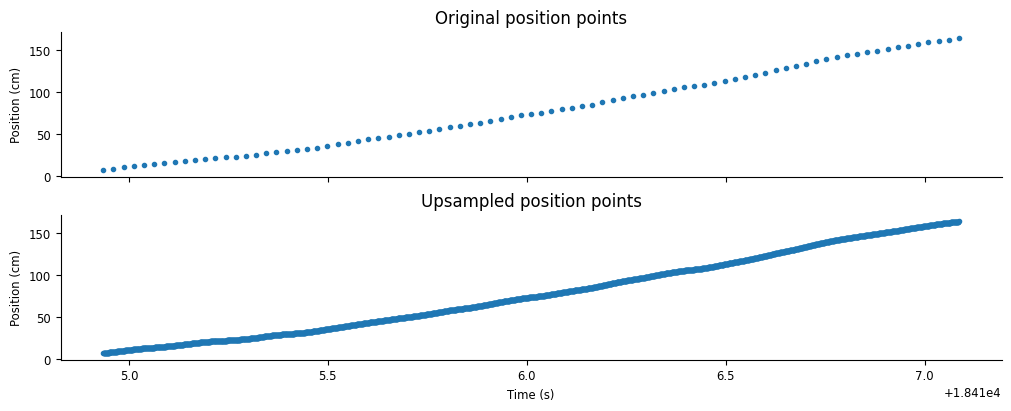

In [95]:
fig,axs = plt.subplots(2,1,constrained_layout=True,sharex=True,figsize=(10,4))
axs[0].plot(position.restrict(ex_run_ep),'.')
axs[0].set(ylabel="Position (cm)", title="Original position points")
axs[1].plot(upsampled_pos.restrict(ex_run_ep),'.')
axs[1].set(ylabel="Position (cm)", xlabel="Time (s)", title="Upsampled position points")

We can now stack `upsampled_pos` and `theta_phase` into a single array.

## 

In [98]:
feats = np.transpose(np.stack((upsampled_pos, theta_phase)))
feats

array([[  7.49215266,   2.17453408],
       [  7.53643596,   2.46385459],
       [  7.58071927,   2.48104542],
       ...,
       [163.74149849,   1.58198304],
       [163.78980754,   1.58187193],
       [163.8381166 ,   1.57692426]])

Using `feats`, we can define a `TsdFrame` using the time index from `theta_phase` and the time support from `upsampled_pos`. Note that `feats` has the wrong shape; we want time in the first dimension, so we'll need to pass its transpose.

In [100]:
features = nap.TsdFrame(
    t = upsampled_pos.t,
    d = feats,
    time_support = upsampled_pos.time_support,
    columns = ['position', 'theta_phase'],
)

Now we have what we need to compute 2D tuning curves. Let's apply `nap.compute_2d_tuning_curves` on our reduced group of units, `good_spikes`, using 20 bins for each feature. 

This function will return two outputs:
1. A dictionary of the 2D tuning curves, where dictionary keys correspond to the unit label
2. A list with length 2 containing the feature bin centers

In [101]:
tuning_curves, [pos_x, phase_y] = nap.compute_2d_tuning_curves(good_spikes, features, nb_bins=20)

We can plot the first 50 2D tuning curves and visualize how many of these units are phase precessing.

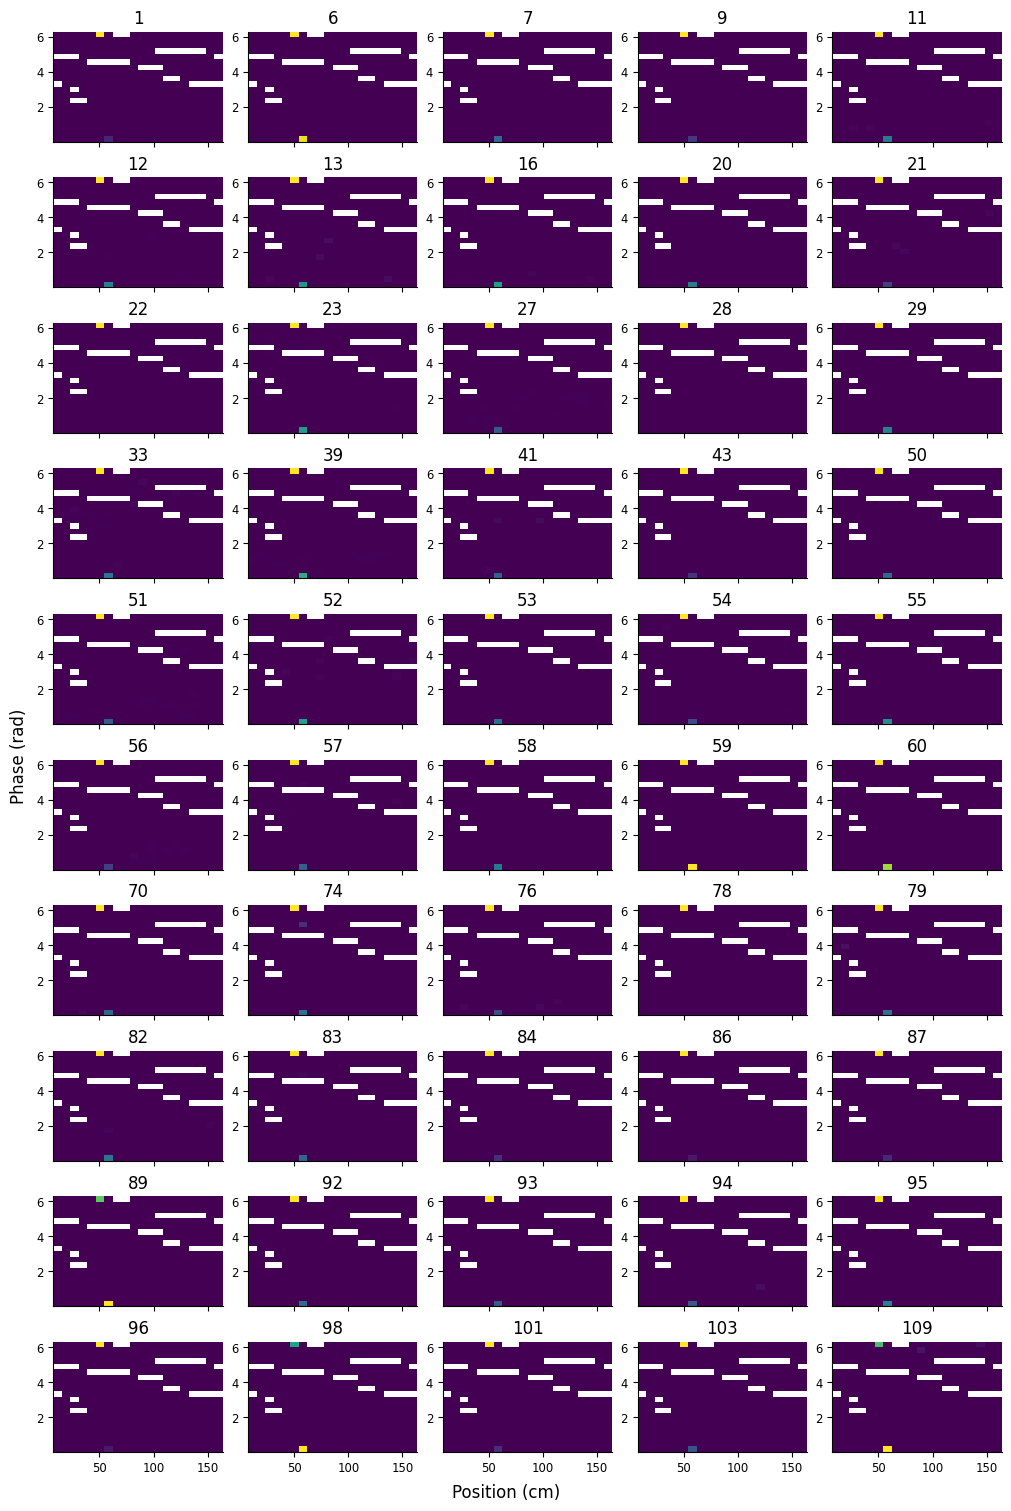

In [102]:
fig, axs = plt.subplots(10, 5, figsize=(10, 15), sharex=True, constrained_layout=True)
for i, f in enumerate(list(tuning_curves.keys())[:50]):
    idx = np.unravel_index(i, axs.shape)
    axs[idx].pcolormesh(pos_x, phase_y, tuning_curves[f])
    axs[idx].set_title(f)

fig.supylabel("Phase (rad)")
fig.supxlabel("Position (cm)");

## Decoding position from spiking activity


Next we'll do a popular analysis in the rat hippocampal sphere: Bayesian decoding. This analysis is an elegent application of Bayes' rule in predicting the animal's location (or other behavioral variables) from neural activity at some point in time.
### Background

For a more in-depth background on Bayesian decoding, see the full version of this notebook online.
### ASIDE: Cross-validation
:::{admonition} Important
:class: important render-user render-presenter

Generally this method is cross-validated, which means you train the model on one set of data and test the model on a different, held-out data set. For Bayesian decoding, the "model" refers to the model *likelihood*, which is computed from the tuning curves. Run the code below if you want to use a separate training set to compute the tuning curves.

:::

In [103]:
# hold out trial from place field computation
run_train = forward_ep.set_diff(ex_run_ep)
# get position of training set
position_train = position.restrict(run_train)
# compute place fields using training set
place_fields = nap.compute_1d_tuning_curves(spikes, position_train, nb_bins=50)
# smooth place fields
place_fields[:] = gaussian_filter1d(place_fields.values, 1, axis=0)

### Run 1D decoder


With a single dimension in our tuning curves (position), we can apply Bayesian decoding using the function `nap.decode_1d`. This function requires the following inputs:
- `tuning_curves`: a `pandas.DataFrame`, computed by `nap.compute_1d_tuning_curves`, with the tuning curves relative to the feature being decoded
- `group`: a `TsGroup` of spike times, or a `TsdFrame` of spike counts, for each unit in `tuning_curves`.
- `ep`: an `IntervalSet` containing the epoch to be decoded
- `bin_size`: the time length, in seconds, of each decoded bin. If `group` is a `TsGroup` of spike times, this determines how the spikes are binned in time. If `group` is a `TsdFrame` of spike counts, this should be the bin size used for the counts.

This function will return two outputs:
- a `Tsd` containing the decoded feature at each decoded time point
- a `TsdFrame` containing the decoded probability of each feature value at each decoded time point, where the column names are the corresponding feature values

To increase decoder accuracy, we'll want to use the tuning curves of all the units in `spikes`. Recompute `place_fields` using `nap.compute_1d_tuning_curves` for all available units. (You can skip this if you're using the cross-validated `place_fields` from above.)

In [104]:
place_fields = nap.compute_1d_tuning_curves(spikes, position, nb_bins=50)

    
Let's decode position during `ex_run_ep` using 50 ms time bins.

In [108]:
decoded_position, decoded_prob = nap.decode_1d(place_fields, spikes, ep=ex_run_ep, bin_size=50, time_units='ms')

Let's plot decoded position with the animal's true position. We'll overlay them on a heat map of the decoded probability to visualize the confidence of the decoder.

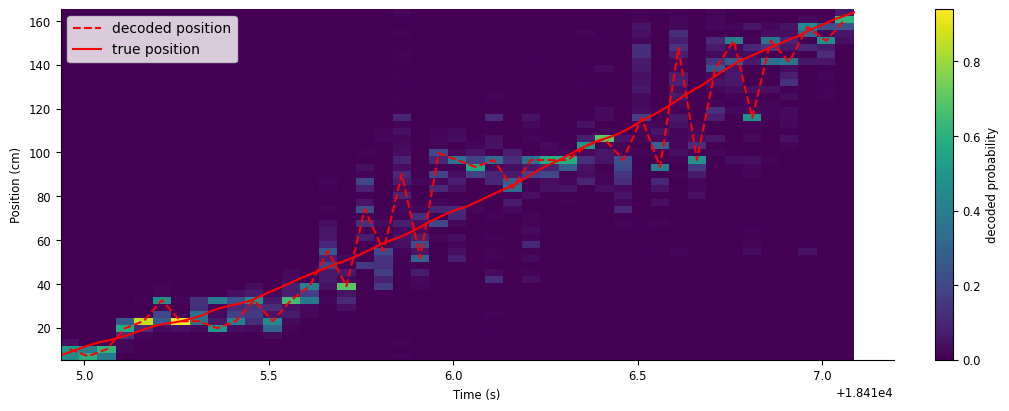

In [109]:
fig,ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
c = ax.pcolormesh(decoded_position.index,place_fields.index,np.transpose(decoded_prob))
ax.plot(decoded_position, "--", color="red", label="decoded position")
ax.plot(ex_position, color="red", label="true position")
ax.legend()
fig.colorbar(c, label="decoded probability")
ax.set(xlabel="Time (s)", ylabel="Position (cm)", );

### Smooth spike counts


One way to improve our decoder is to supply smoothed spike counts to `nap.decode_1d`. We can smooth the spike counts by convolving them with a kernel of ones; this is equivalent to applying a moving sum to adjacent bins, where the length of the kernel is the number of adjacent bins being added together. You can think of this as counting spikes in a *sliding window* that shifts in shorter increments than the window's width, resulting in bins that overlap. This combines the accuracy of using a wider time bin with the temporal resolution of a shorter time bin.

In [110]:
ex_counts = spikes[unit].restrict(ex_run_ep).count(0.04)
workshop_utils.animate_1d_convolution(ex_counts, np.ones(5), tsd_label="original counts", kernel_label="moving sum", conv_label="convolved counts")

Let's compute the smoothed counts for all units.

1. On spike times restricted to `ep_run_ep`, count spikes in $40 ms$ bins using the pynapple object method `count`.

In [113]:
counts = spikes.count(bin_size=40, time_units='ms', ep=ex_run_ep)

2. Convolve the counts with the kernel `np.ones(5)` using the pynapple object method `convolve`.

In [114]:
smth_counts = counts.convolve(np.ones(5))

Now we can use `nap.decode_1d` again with our smoothed counts in place of the raw spike times. Note that the bin size we'll want to provide is $200 ms$, since this is the true width of each bin.

In [120]:
smth_decoded_position, smth_decoded_prob = nap.decode_1d(place_fields, smth_counts, ep=ex_run_ep, bin_size=0.2)

Let's plot the results.

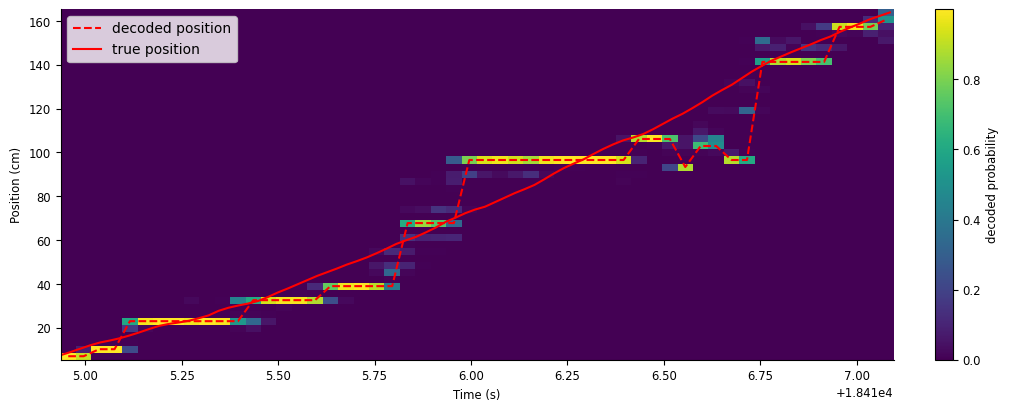

In [121]:
fig,ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
c = ax.pcolormesh(smth_decoded_position.index,place_fields.index,np.transpose(smth_decoded_prob))
ax.plot(smth_decoded_position, "--", color="red", label="decoded position")
ax.plot(ex_position, color="red", label="true position")
ax.legend()
fig.colorbar(c, label="decoded probability")
ax.set(xlabel="Time (s)", ylabel="Position (cm)", );

### Bonus: theta sequences


Units phase precessing together creates fast, spatial sequences around the animal's true position. We can reveal this by decoding at an even shorter time scale, which will appear as smooth errors in the decoder.

1. Get smoothed counts for a sliding window of $50 ms$ shifted by $10 ms$.

In [124]:
smth_counts = spikes.restrict(ex_run_ep).count(0.01).convolve(np.ones(5))

2. Use `nap.decode_1d` to get the smoothed decoded position.

In [127]:
smth_decoded_position, smth_decoded_prob = nap.decode_1d(place_fields, smth_counts, ex_run_ep, bin_size=0.05)

    
We'll make the same plot as before to visualize the results, but plot it alongside the raw and filtered LFP.

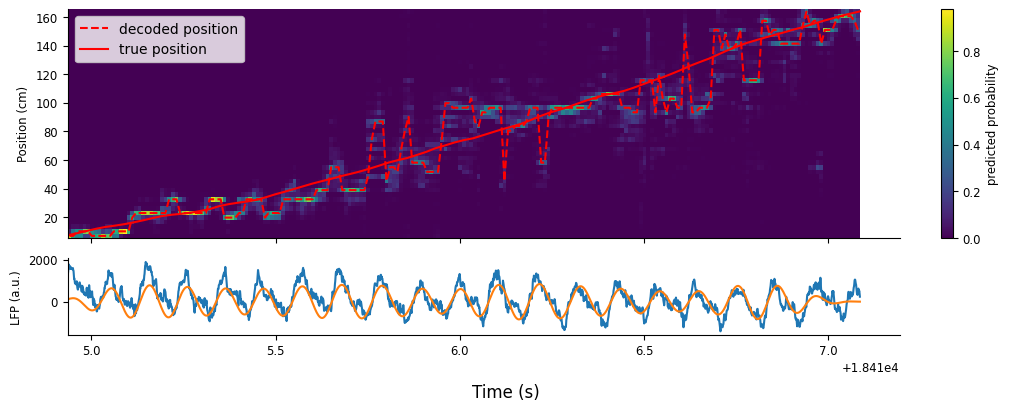

In [128]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), constrained_layout=True, height_ratios=[3,1], sharex=True)
c = axs[0].pcolormesh(smth_decoded_prob.index, smth_decoded_prob.columns, np.transpose(smth_decoded_prob))
p1 = axs[0].plot(smth_decoded_position, "--", color="r")
p2 = axs[0].plot(ex_position, color="r")
axs[0].set_ylabel("Position (cm)")
axs[0].legend([p1[0],p2[0]],["decoded position","true position"])
fig.colorbar(c, label = "predicted probability")

axs[1].plot(ex_lfp_run)
axs[1].plot(theta_band.restrict(ex_run_ep))
axs[1].set_ylabel("LFP (a.u.)")

fig.supxlabel("Time (s)");